## Conclusiones
* Fueron usados 7 modelos de Machine Learning para predecir la cantidad de temporadas que tendría un Show de TV de Netflix a partir del actor principal, país del show, director, rating, entre otras variables.

* El mejor modelo fue el de Random Forest Classifier con un puntaje recall de 0.69, es decir, predijo correctamente el 69% de los datos.

* Las variables que más influyen para calcular la cantidad de temporadas son el actor principal (23.12%) y la categoría principal del show (19.99%).

* La información podría ser de ayuda para Netflix en su selección de actores y categoría de cada show para estimar el potencial de éxito de sus shows de TV.


### Librerías

In [79]:
import pandas as pd; import numpy as np; import matplotlib.pyplot as plt; import seaborn as sns

### Preprocesamiento

In [80]:
##-----Cantidad de valores nulos por columna y su porcentaje respecto al total

df = pd.read_csv('netflix_titles.csv')

def missing_values(df):
    duplicados = df.duplicated().sum()
    print(f'El Dataframe tiene {df.shape[0]} registros y {duplicados} valores duplicados'.center(70, '-'))
    print('')
    for i,col in enumerate(df):
        missing = df[col].isna().sum()
        missing_percentage = df[col].isna().sum()/df.shape[0]*100
        print(f'La columna {col} tiene << {missing} ({missing_percentage:.2f}%) >> valores nulos.')

missing_values(df)

##Eliminar las columnas innecesarias
df = df.drop(columns=['show_id','description','title'])

-------El Dataframe tiene 8807 registros y 0 valores duplicados-------

La columna show_id tiene << 0 (0.00%) >> valores nulos.
La columna type tiene << 0 (0.00%) >> valores nulos.
La columna title tiene << 0 (0.00%) >> valores nulos.
La columna director tiene << 2634 (29.91%) >> valores nulos.
La columna cast tiene << 825 (9.37%) >> valores nulos.
La columna country tiene << 831 (9.44%) >> valores nulos.
La columna date_added tiene << 10 (0.11%) >> valores nulos.
La columna release_year tiene << 0 (0.00%) >> valores nulos.
La columna rating tiene << 4 (0.05%) >> valores nulos.
La columna duration tiene << 3 (0.03%) >> valores nulos.
La columna listed_in tiene << 0 (0.00%) >> valores nulos.
La columna description tiene << 0 (0.00%) >> valores nulos.


In [81]:
##-----Llenar valores nulos con la media y la moda.
cat = df.select_dtypes('O')
num = df.select_dtypes('number')

for i, col in enumerate(cat):
    cat[col] = cat[col].fillna(cat[col].mode()[0])

for i, col in enumerate(num):
    num[col] = num[col].fillna(num[col].mean())

df[cat.columns] = cat
df[num.columns] = num

##-----Conversión de tipos de datos.
#-------La columna date_added debería ser tipo fecha pero es necesario hacer una correción antes
df['date_added']=df['date_added'].str.strip(' ')
df['date_added'] = pd.to_datetime(df['date_added'],format='%B %d, %Y')

df['release_year'] = df['release_year'].astype(np.int16)

# ##Obtener columna de años desde estreno hasta lanzamiento en netlix

# df['year_to_netflix'] = df['date_added'].dt.year - df['release_year']

### Estilos para los gráficos

In [82]:
#-------------------------Estilos para los gráficos
import matplotlib as mpl
plt.style.use("fivethirtyeight") 
mpl.rcParams["font.size"]=10.5 
mpl.rcParams["legend.fontsize"]=14
mpl.rcParams["font.family"]="serif"
mpl.rcParams["font.weight"]="bold"
mpl.rcParams["legend.fancybox"]=True
mpl.rcParams["xtick.labelsize"]=10
mpl.rcParams["ytick.labelsize"]=16
mpl.rcParams["figure.titleweight"]="bold"
mpl.rcParams["axes.labelweight"]="bold"
mpl.rcParams["figure.facecolor"]="white"
mpl.rcParams["axes.facecolor"]="white"
mpl.rcParams["axes.edgecolor"]="0.2"
mpl.rcParams["axes.linewidth"]=1
mpl.rcParams["axes.titleweight"]="bold"
mpl.rcParams["axes.labelsize"]=16
mpl.rcParams["figure.titlesize"]=20
mpl.rcParams["axes.titlesize"]=25
mpl.rcParams["figure.labelsize"]=16
mpl.rcParams["figure.labelweight"]="bold"
mpl.rcParams['axes.grid']=False

In [83]:
##-----Descartar valores atípicos en base al año de estreno

q1 = df['release_year'].quantile(0.25)
q3 = df['release_year'].quantile(0.75)

iqr = q3 - q1

df = df.loc[(df['release_year']>=q1-1.5*iqr)&(df['release_year']<=q3+1.5*iqr)]

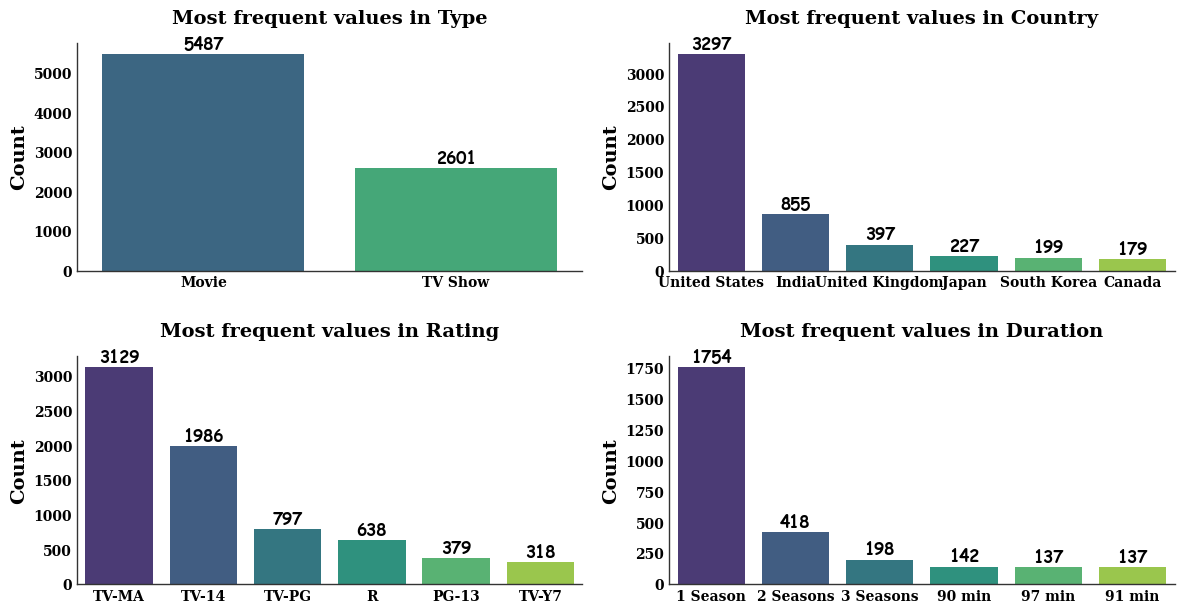

In [84]:
##-----Distribución de los datos
cols_borrar = ['director','cast','listed_in']
cat = df.select_dtypes('O').drop(columns=cols_borrar)


fig, ax = plt.subplots(figsize=(12,6),ncols=2,nrows=round(cat.shape[1]/2))
fig.tight_layout(h_pad=4)
ax = ax.flat

for i, col in enumerate(cat):
    
    conteo = cat[col].value_counts(sort=True).reset_index().head(6)
    bar = sns.barplot(data=conteo,x=col,y='count',ax=ax[i],hue=col,palette='viridis')
    for container in bar.containers:
        bar.bar_label(container,fontsize=12,fontfamily='cursive',fontweight='bold')

    ax[i].set_xlabel('')
    ax[i].set_ylabel('Count',fontdict=dict(weight='bold',size=14))
    ax[i].set_title('Most frequent values in' + f' {col}'.title(),fontdict=dict(size=14,weight='bold'),y=1.05)
    ax[i].spines[['top','right']].set_visible(False)
    ax[i].tick_params(axis='y',labelsize=10)
    

plt.show()


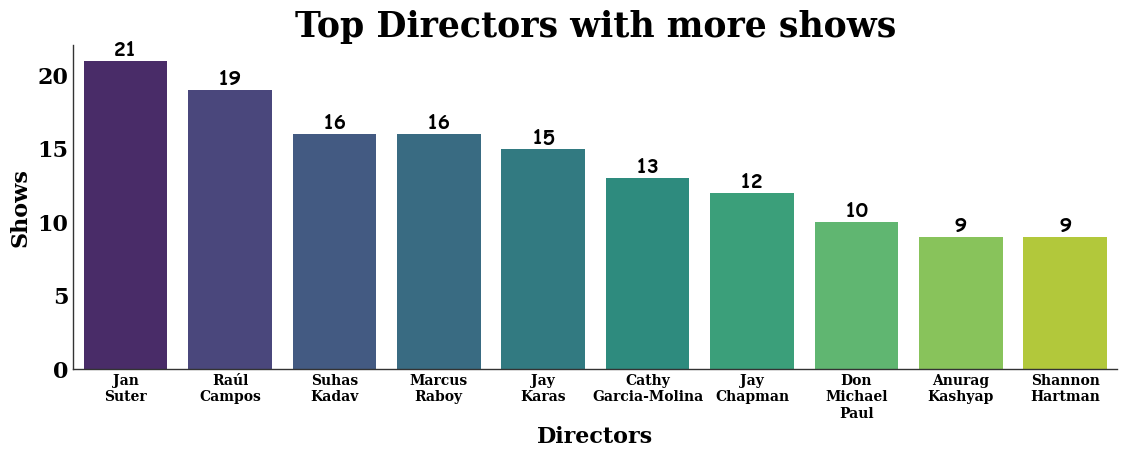

In [85]:
##----- Análisis de las columnas director, cast y listed_in

##------Director
top = df['director'].str.split(', ',expand=True).stack().value_counts(sort=True).head(11).reset_index().drop(0,axis=0)

fig, ax = plt.subplots(figsize=(12,4))
bar = sns.barplot(data=top,x='index',y='count',hue='index',palette='viridis')
def estetica_individual(titulo):
    ax.spines[['top','right']].set_visible(False)
    ax.set_title(f'Top {titulo} with more shows')
    ax.set_xlabel(titulo)
    ax.set_ylabel('Shows')
    labels = [i.replace(' ','\n') for i in top.iloc[:,0]]
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels)

    for container in bar.containers:
        ax.bar_label(container,fontfamily='cursive',fontweight='bold',fontsize=14)
    
estetica_individual('Directors')

plt.show()

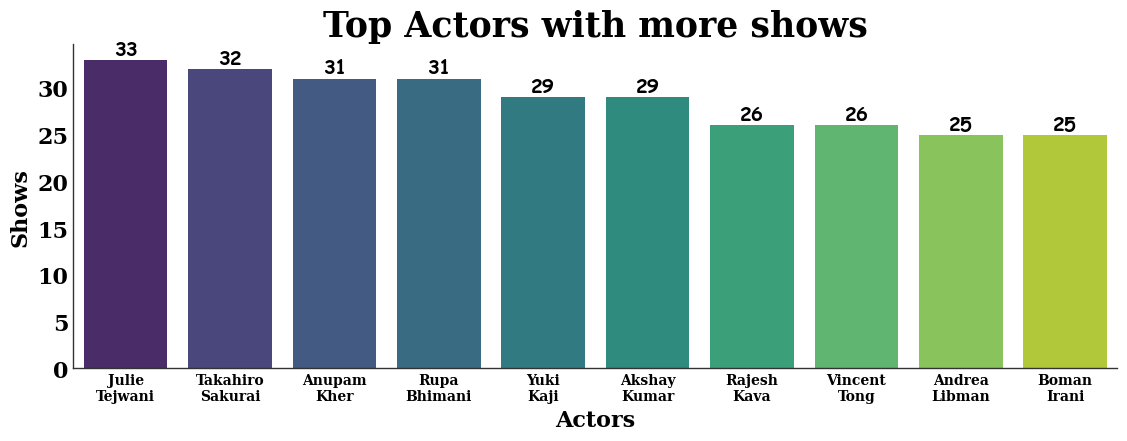

In [86]:
top = df['cast'].str.split(', ',expand=True).stack().value_counts(sort=True).head(11).reset_index().drop(0,axis=0)

fig, ax = plt.subplots(figsize=(12,4))
bar = sns.barplot(data=top,x='index',y='count',hue='index',palette='viridis')
def estetica_individual(titulo):
    ax.spines[['top','right']].set_visible(False)
    ax.set_title(f'Top {titulo} with more shows')
    ax.set_xlabel(titulo)
    ax.set_ylabel('Shows')
    labels = [i.replace(' ','\n') for i in top.iloc[:,0]]
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels)

    for container in bar.containers:
        ax.bar_label(container,fontfamily='cursive',fontweight='bold',fontsize=14)
    
estetica_individual('Actors')

plt.show()

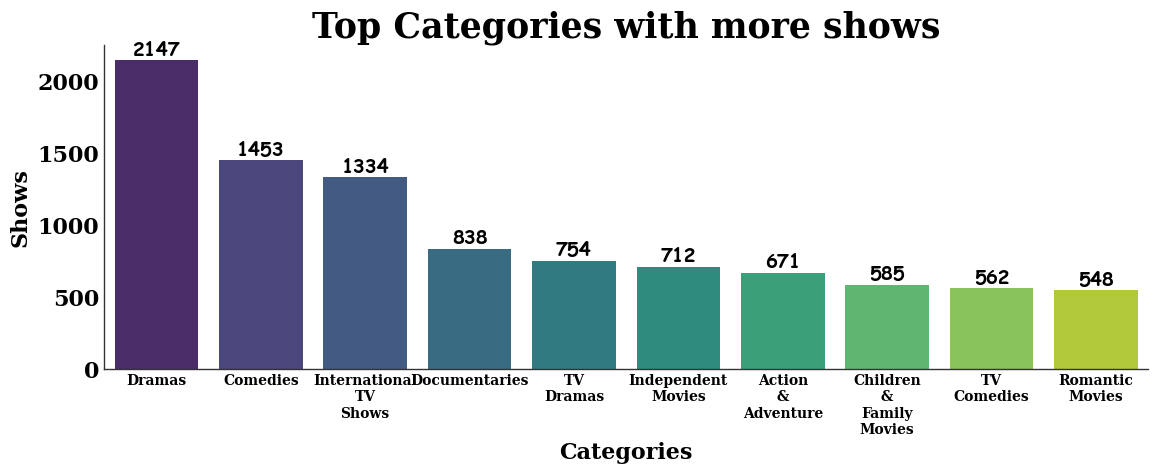

In [87]:
top = df['listed_in'].str.split(', ',expand=True).stack().value_counts(sort=True).head(11).reset_index().drop(0,axis=0)

fig, ax = plt.subplots(figsize=(12,4))
bar = sns.barplot(data=top,x='index',y='count',hue='index',palette='viridis')
def estetica_individual(titulo):
    ax.spines[['top','right']].set_visible(False)
    ax.set_title(f'Top {titulo} with more shows')
    ax.set_xlabel(titulo)
    ax.set_ylabel('Shows')
    labels = [i.replace(' ','\n') for i in top.iloc[:,0]]
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels)

    for container in bar.containers:
        ax.bar_label(container,fontfamily='cursive',fontweight='bold',fontsize=14)
    
estetica_individual('Categories')


plt.show()

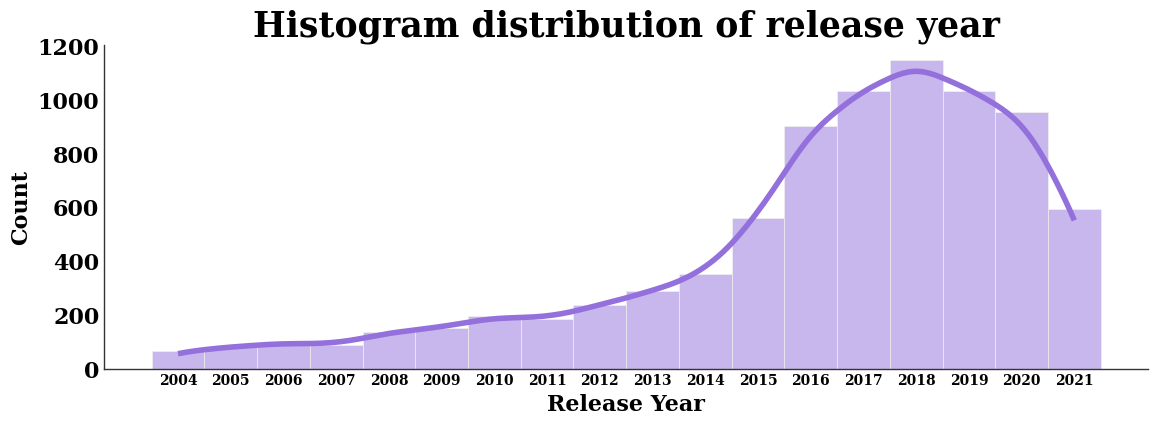

In [88]:
##-----Distribucion de los datos de año de estreno

fig, ax = plt.subplots(figsize=(12,4))

release = df['release_year']

sns.histplot(data=release,bins=25,discrete=True,kde=True,color='mediumpurple')
ax.spines[['top','right']].set_visible(False)
ax.set_title('Histogram distribution of release year')
ax.set_xticks(release.unique())
ax.set_xlabel('Release Year')

plt.show()

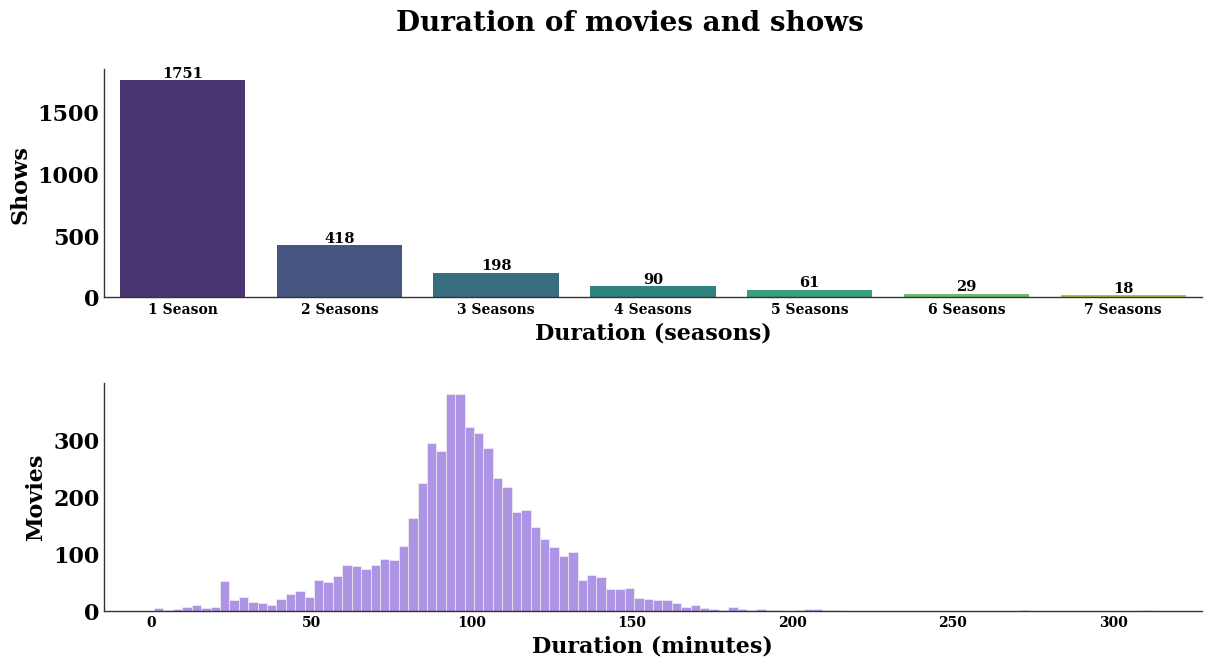

In [89]:
##-----Distribucion de la duracion de series y peliculas

movies = df.loc[df['type']=='Movie'].drop(columns='type')
shows = df.loc[df['type']=='TV Show'].drop(columns='type')

seasons = shows['duration'].value_counts(sort=True).head(7).reset_index()
minutes = movies['duration'].str.split(expand=True).drop(columns=1).astype(np.int16)


fig, ax = plt.subplots(figsize=(12,6),nrows=2)
fig.tight_layout(h_pad=4)
fig.suptitle('Duration of movies and shows',y=1.06)
bar = sns.barplot(data=seasons,ax=ax[0],x='duration',y='count',hue='duration',palette='viridis')
sns.histplot(data=minutes,ax=ax[1],x=0,color='mediumpurple')

ax[1].set_xlabel('Duration (minutes)')
ax[0].set_xlabel('Duration (seasons)')
ax[0].set_ylabel('Shows')
ax[1].set_ylabel('Movies')
for i in range(2):
    ax[i].spines[['top','right']].set_visible(False)
    
for container in bar.containers:
    ax[0].bar_label(container)


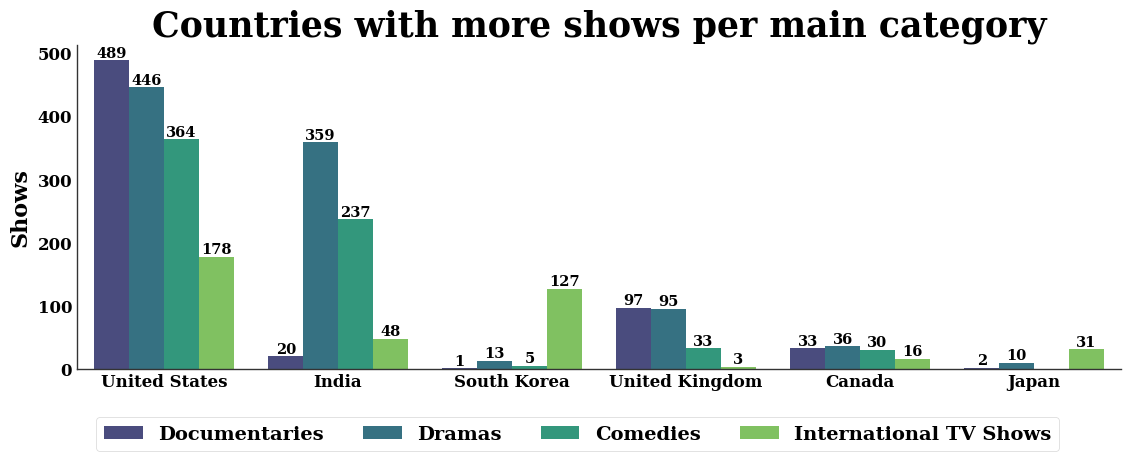

In [90]:
###Categoría de cada show por pais

##Es necesario crear una columna con la categoría principal de cada show
df['main_cat'] = df['listed_in'].str.split(', ',expand=True)[0]
df['country'] = df['country'].str.split(', ',expand=True)[0]

##Paso 1: Hallar los paises con más producciones y el tipo de show más comun
top_countries = df['country'].value_counts(sort=True).head(6)
top_countries = top_countries.index

top_main_cat = df['main_cat'].value_counts(sort=True).head(4)
top_main_cat = top_main_cat.index

##Paso 2: Obtener un df con informacion de esos paises 
df_countries = df.loc[df['country'].isin(top_countries)]
##Paso 3: agrupar los datos y filtrar de nuevo
country_category = df_countries.groupby(['country','main_cat'])['type'].count().reset_index()
country_category = country_category.loc[country_category['main_cat'].isin(top_main_cat)].sort_values(by='type',ascending=False)
##Paso 4: graficar
fig, ax = plt.subplots(figsize=(12,4))
bar = sns.barplot(data=country_category,x='country',y='type',hue='main_cat',palette='viridis')

for container in bar.containers:
    ax.bar_label(container)

ax.spines[['top','right']].set_visible(False)
ax.legend(bbox_to_anchor=(0.95,-0.12),ncols=4)
ax.set_xlabel('')
ax.set_ylabel('Shows')
ax.set_title('Countries with more shows per main category')
ax.tick_params(axis='both',labelsize=12)
plt.show()

## Proceso de Machine Learning

In [91]:
##-----El objetivo es predecir la cantidad de temporadas que tendrá una serie a partir de las demás variables

###Vamos a obtener una columna donde solo esté el actor principal de cada show y la cantidad de temporadas

df['actor'] = df['cast'].str.split(', ',expand=True)[0]
df['seasons'] = df['duration'].str.split(' ',expand=True)[0].astype(np.int16)
df['date_added'] = df['date_added'].dt.year
shows = df.loc[df['type']=='TV Show'].drop(columns=['type','listed_in','cast','duration']).sort_index(axis=1)

##Vamos a usar el label enconder para convertir las variables categóricas a numéricas

from sklearn.preprocessing import LabelEncoder

enconder = LabelEncoder()

cat = shows.select_dtypes('O')

for i, col in enumerate(cat):
    shows[col] = enconder.fit_transform(shows[col])


<Axes: >

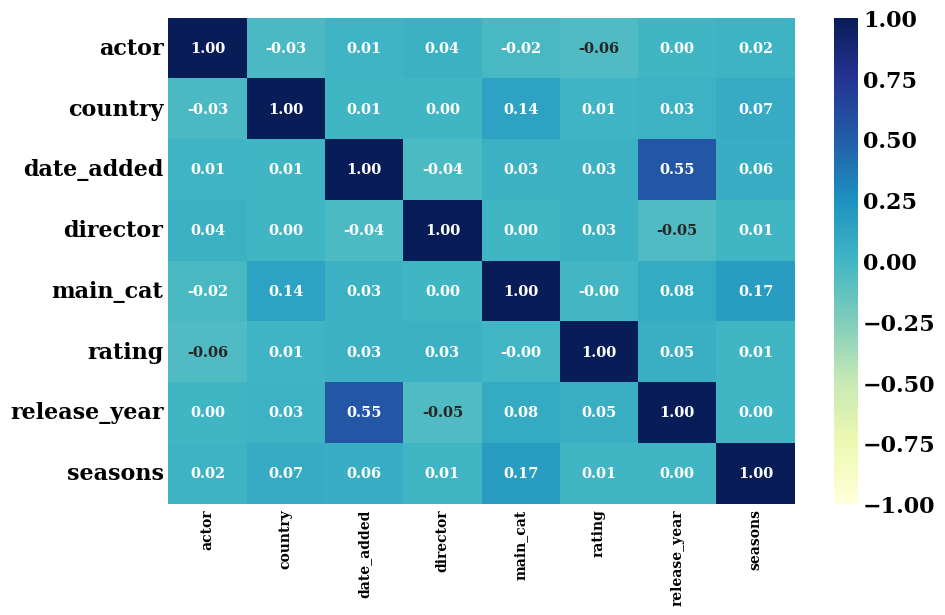

In [92]:
##Determinar correlaciones

corr = shows.corr()
fig, ax = plt.subplots(figsize=(9,6))
sns.heatmap(corr,annot=True,cmap='YlGnBu',ax=ax,vmin=-1,fmt='.2f')

In [93]:
x = shows.drop(columns='seasons')
y = shows['seasons']

from sklearn.model_selection import train_test_split

x_train,x_test,y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=123)

In [111]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import ComplementNB

from sklearn.metrics import precision_score, recall_score,f1_score

models = {
    'Logistic Regression':LogisticRegression(n_jobs=-1),
    'KNN':KNeighborsClassifier(n_jobs=-1),
    'SVM':SVC(),
    'Decission Tree':DecisionTreeClassifier(),
    'Random Forest':RandomForestClassifier(n_jobs=-1),
    'Gaussian NB':GaussianNB(),
    'Complement NB': ComplementNB()
}
metodo = 'weighted'
def evaluar_modelos(models=models):

    best_score = 0
    best_model = None

    for name, model in models.items():
        y_pred = model.fit(x_train,y_train).predict(x_test)
        precision = precision_score(y_true=y_test,y_pred=y_pred,average=metodo,zero_division=1)
        recall = recall_score(y_true=y_test,y_pred=y_pred,average=metodo,zero_division=1)
        f1 = f1_score(y_true=y_test,y_pred=y_pred,average=metodo,zero_division=1)
        
        # print(f'\nEl modelo {model} tiene:\n',f'Precision: {precision} - Recall: {recall} - F1: {f1}')
        if f1>best_score:
            best_score=f1; best_model=model
        else:
            best_score=best_score; best_model=best_model
    print(f'El mejor modelo es {best_model} con un F1 de {best_score:.4f}')

    return best_model
model = evaluar_modelos()

El mejor modelo es RandomForestClassifier(n_jobs=-1) con un F1 de 0.5942


### Ajuste de hiperparámetros para mejorar el rendimiento

In [131]:
from sklearn.model_selection import GridSearchCV

grilla = {
 'criterion': ['gini','entropy','log_loss'],
 'max_depth': np.arange(0,18,2),
 'max_features': ['sqrt','log2',None],
 'max_leaf_nodes': np.arange(100,200,20),
 'n_estimators': np.arange(100,150,10),

}
def ajuste_parametros(grilla=grilla):
    grid = GridSearchCV(estimator=RandomForestClassifier(n_jobs=-1),param_grid=grilla,cv=3,verbose=1)
    grid.fit(x_train,y_train)
    print(f'El mejor puntaje es: {grid.best_score_:.4f}')
    print(f'Los mejores parámetros son {grid.best_params_}')
    model = grid.best_estimator_
    y_pred = model.fit(x_train,y_train).predict(x_test)

    f1 = f1_score(y_test, y_pred,average='weighted')

    print(f'El mejor F1 es: {f1:.3f}')
    
    return grid.best_estimator_

model = ajuste_parametros()

Fitting 3 folds for each of 2025 candidates, totalling 6075 fits


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
675 fits failed out of a total of 6075.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
675 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\User\App

El mejor puntaje es: 0.6745
Los mejores parámetros son {'criterion': 'gini', 'max_depth': 8, 'max_features': 'log2', 'max_leaf_nodes': 180, 'n_estimators': 120}
El mejor F1 es: 0.588


In [139]:
y_pred = model.predict(x_test)

f1 = f1_score(y_test,y_pred,average='weighted',zero_division=1)
recall = recall_score(y_test,y_pred,average='weighted',zero_division=1)
precision = precision_score(y_test,y_pred,average='weighted',zero_division=1)
f1 , recall , precision

(0.5883904066586543, 0.6890595009596929, 0.683278310940499)

In [149]:
##Importancia de cada categoría

importancias = model.feature_importances_
nombres = model.feature_names_in_

for i in range(len(nombres)):
    print(f'La variable {nombres[i]} influye un --> {importancias[i]*100:.2f}% a la cantidad de temporadas')

La variable actor influye un --> 23.12% a la cantidad de temporadas
La variable country influye un --> 13.32% a la cantidad de temporadas
La variable date_added influye un --> 11.87% a la cantidad de temporadas
La variable director influye un --> 5.55% a la cantidad de temporadas
La variable main_cat influye un --> 19.99% a la cantidad de temporadas
La variable rating influye un --> 12.76% a la cantidad de temporadas
La variable release_year influye un --> 13.38% a la cantidad de temporadas
